#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam
from sklearn.metrics import *

### (2) 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [3]:
data=pd.read_csv('/content/drive/MyDrive/딥러닝/미프3/data01_train.csv')
data.drop(columns='subject', axis=1, inplace=True)
new_data=pd.read_csv('/content/drive/MyDrive/딥러닝/미프3/data01_test.csv')

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [4]:
is_dynamic = data['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
data['Activity_dynamic']=is_dynamic

is_dynamic = new_data['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
new_data['Activity_dynamic']=is_dynamic



In [5]:
new_data.drop(columns='subject', axis=1, inplace=True)

In [6]:
x=data.drop(columns=['Activity', 'Activity_dynamic'], axis=1)
y_1=data['Activity']
y_2=data['Activity_dynamic']

x_test=new_data.drop(columns=['Activity', 'Activity_dynamic'], axis=1)
y_1_test=new_data['Activity']
y_2_test=new_data['Activity_dynamic']

In [7]:
x_train_1, x_val_1, y_train_1, y_val_1=train_test_split(x, y_1, train_size=0.7, random_state=1)
x_train_2, x_val_2, y_train_2, y_val_2=train_test_split(x, y_2, train_size=0.7, random_state=1)

In [8]:
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 :

In [9]:
# 메모리 정리
clear_session()

# 모델링
nfeatures=561
model = Sequential(
   [ Dense(128, input_shape = (nfeatures,), activation = 'relu'),
    Dense(64, activation='relu'),
    Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid') ]
    )

# 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               71936     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 81249 (317.38 KB)
Trainable params: 81249 (317.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'binary_crossentropy')

history = model.fit(x_train_2, y_train_2, epochs = 20, validation_split=0.2).history

Epoch 1/20
103/103 [==============================] - 3s 12ms/step - loss: 0.0604 - val_loss: 1.7381e-04
Epoch 2/20
103/103 [==============================] - 1s 14ms/step - loss: 6.1254e-04 - val_loss: 4.2883e-05
Epoch 3/20
103/103 [==============================] - 1s 12ms/step - loss: 6.5810e-04 - val_loss: 6.7722e-05
Epoch 4/20
103/103 [==============================] - 1s 14ms/step - loss: 5.9720e-06 - val_loss: 1.5374e-05
Epoch 5/20
103/103 [==============================] - 1s 11ms/step - loss: 1.1335e-06 - val_loss: 1.0086e-05
Epoch 6/20
103/103 [==============================] - 1s 7ms/step - loss: 9.4346e-07 - val_loss: 8.8609e-06
Epoch 7/20
103/103 [==============================] - 1s 10ms/step - loss: 8.6444e-07 - val_loss: 6.2559e-06
Epoch 8/20
103/103 [==============================] - 1s 8ms/step - loss: 7.6351e-07 - val_loss: 5.3826e-06
Epoch 9/20
103/103 [==============================] - 1s 8ms/step - loss: 7.0595e-07 - val_loss: 4.8964e-06
Epoch 10/20
103/103 [=====

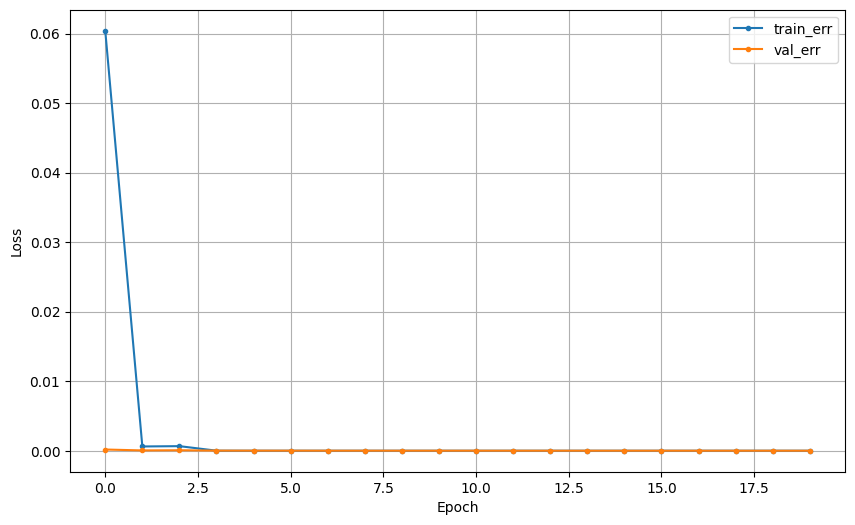

In [11]:
dl_history_plot(history)

In [12]:
pred=model.predict(x_val_2)

pred=np.where(pred>0.5, 1, 0)

56/56 [==============================] - 0s 2ms/step


In [13]:
print(classification_report(y_val_2, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [14]:
pred=model.predict(x_test)

pred=np.where(pred>0.5, 1, 0)

46/46 [==============================] - 0s 2ms/step


In [15]:
print(classification_report(y_2_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



#### 2) 알고리즘2 :

### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [16]:
indices_to_keep = y_train_1[y_train_1.isin(['LAYING', 'SITTING', 'STANDING'])].index
x_train_temp=x_train_1.loc[indices_to_keep]
y_train_temp=y_train_1[indices_to_keep]

In [17]:
indices_to_keep = y_val_1[y_val_1.isin(['LAYING', 'SITTING', 'STANDING'])].index

x_val_temp=x_val_1.loc[indices_to_keep]
y_val_temp=y_val_1[indices_to_keep]

In [18]:
indices_to_keep = y_1_test[y_1_test.isin(['LAYING', 'SITTING', 'STANDING'])].index
new_y_1_test=y_1_test[indices_to_keep]
new_x_test=x_test.loc[indices_to_keep]

In [19]:
label_map={0: 'LAYING', 1: 'SITTING', 2: 'STANDING'}
y_train_temp.replace('LAYING', 0, inplace=True)
y_train_temp.replace('SITTING', 1, inplace=True)
y_train_temp.replace('STANDING', 2, inplace=True)
y_val_temp.replace('LAYING', 0, inplace=True)
y_val_temp.replace('SITTING', 1, inplace=True)
y_val_temp.replace('STANDING', 2, inplace=True)
new_y_1_test.replace('LAYING', 0, inplace=True)
new_y_1_test.replace('SITTING', 1, inplace=True)
new_y_1_test.replace('STANDING', 2, inplace=True)
print(y_train_temp)

2196    0
749     1
3271    0
4610    2
4925    2
       ..
144     0
5056    0
2763    1
3980    0
5157    2
Name: Activity, Length: 2280, dtype: int64


In [20]:
# 메모리 정리
clear_session()

# 모델링
nfeatures=561
model = Sequential(
   [ Dense(187, input_shape = (nfeatures,), activation = 'relu'),
    Dense(65, activation='relu'),
    Dense(17, activation='relu'),
    Dense(3, activation = 'softmax') ]
    )

# 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 187)               105094    
                                                                 
 dense_1 (Dense)             (None, 65)                12220     
                                                                 
 dense_2 (Dense)             (None, 17)                1122      
                                                                 
 dense_3 (Dense)             (None, 3)                 54        
                                                                 
Total params: 118490 (462.85 KB)
Trainable params: 118490 (462.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy')

history=model.fit(x_train_temp, y_train_temp, epochs=50, validation_split=0.2).history

Epoch 1/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0693 - val_loss: 0.9762
Epoch 2/50
57/57 [==============================] - 0s 7ms/step - loss: 0.8950 - val_loss: 0.7947
Epoch 3/50
57/57 [==============================] - 0s 7ms/step - loss: 0.7281 - val_loss: 0.5966
Epoch 4/50
57/57 [==============================] - 0s 7ms/step - loss: 0.5242 - val_loss: 0.4388
Epoch 5/50
57/57 [==============================] - 0s 8ms/step - loss: 0.4153 - val_loss: 0.3527
Epoch 6/50
57/57 [==============================] - 0s 8ms/step - loss: 0.3542 - val_loss: 0.3105
Epoch 7/50
57/57 [==============================] - 0s 8ms/step - loss: 0.3106 - val_loss: 0.2945
Epoch 8/50
57/57 [==============================] - 0s 8ms/step - loss: 0.2760 - val_loss: 0.2441
Epoch 9/50
57/57 [==============================] - 0s 7ms/step - loss: 0.2574 - val_loss: 0.2315
Epoch 10/50
57/57 [==============================] - 0s 5ms/step - loss: 0.2314 - val_loss: 0.2101
Epoch 11/50
57/57 [

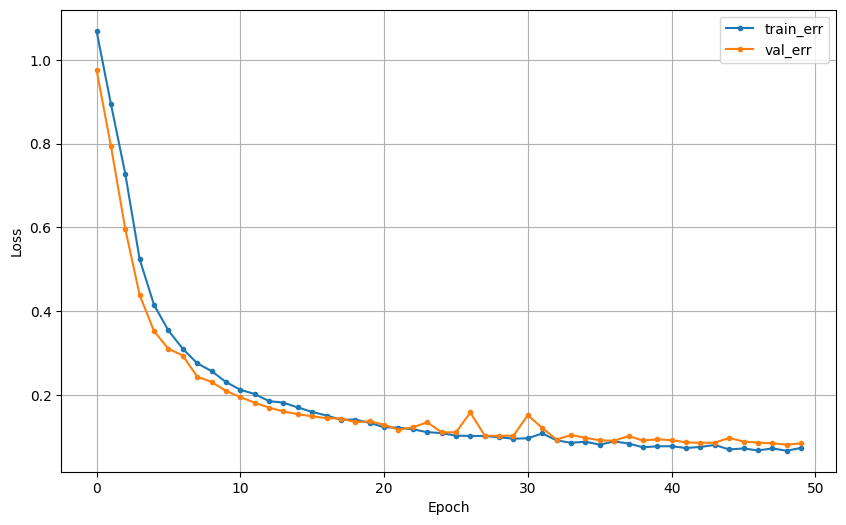

In [22]:
dl_history_plot(history)

In [23]:
pred=model.predict(x_val_temp)

pred=np.argmax(pred, axis=1)
# print(pred)

30/30 [==============================] - 0s 2ms/step


In [24]:
print(classification_report(y_val_temp, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       0.93      0.96      0.94       292
           2       0.97      0.93      0.95       331

    accuracy                           0.97       954
   macro avg       0.96      0.97      0.96       954
weighted avg       0.97      0.97      0.97       954



In [25]:
pred=model.predict(new_x_test)

pred=np.argmax(pred, axis=1)
print(classification_report(new_y_1_test, pred))

27/27 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.93      0.94      0.93       254
           2       0.95      0.93      0.94       287

    accuracy                           0.96       833
   macro avg       0.96      0.96      0.96       833
weighted avg       0.96      0.96      0.96       833



In [42]:
from sklearn.ensemble import GradientBoostingClassifier

GradientBoostingClassifier accuracy: 0.967940813810111
Confusion Matrix:
[[290   2   5]
 [  7 265   3]
 [  0   9 230]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       297
           1       0.96      0.96      0.96       275
           2       0.97      0.96      0.96       239

    accuracy                           0.97       811
   macro avg       0.97      0.97      0.97       811
weighted avg       0.97      0.97      0.97       811



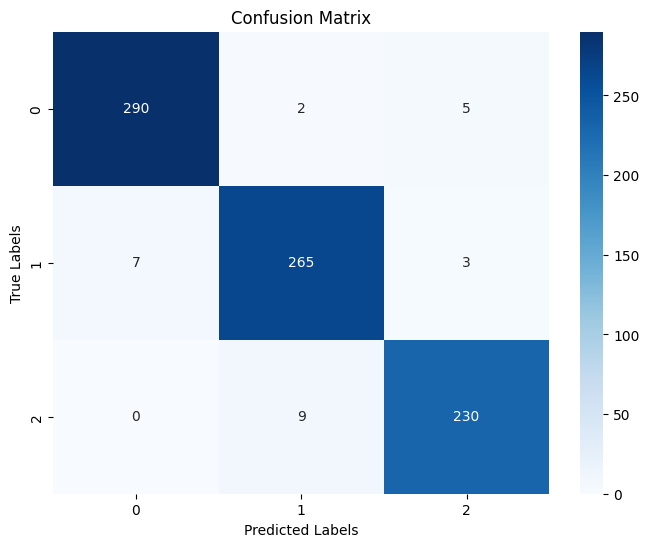

In [43]:
model_optimized = GradientBoostingClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=10
)
model_optimized.fit(x_train_temp, y_train_temp)

predictions = model_optimized.predict(x_val_temp)
accuracy = accuracy_score(y_val_temp, predictions)
print(f'GradientBoostingClassifier accuracy: {accuracy}')


conf_matrix = confusion_matrix(y_val_temp, predictions)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_val_temp, predictions))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

GradientBoostingClassifier accuracy: 0.9686520376175548
Confusion Matrix:
[[223   5   0]
 [  6 206   3]
 [  4   2 189]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       228
           1       0.97      0.96      0.96       215
           2       0.98      0.97      0.98       195

    accuracy                           0.97       638
   macro avg       0.97      0.97      0.97       638
weighted avg       0.97      0.97      0.97       638



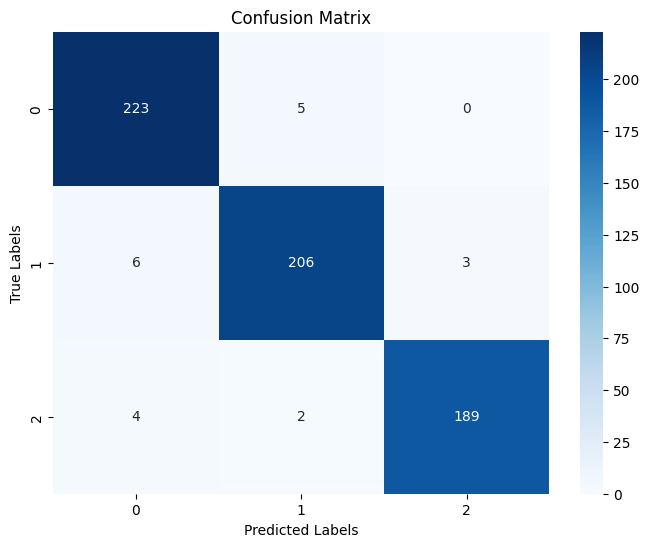

In [44]:
predictions = model_optimized.predict(new_x_test)
accuracy = accuracy_score(new_y_1_test, predictions)
print(f'GradientBoostingClassifier accuracy: {accuracy}')


conf_matrix = confusion_matrix(new_y_1_test, predictions)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(new_y_1_test, predictions))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [26]:
indices_to_keep = y_train_1[y_train_1.isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])].index
x_train_temp=x_train_1.loc[indices_to_keep]
y_train_temp=y_train_1[indices_to_keep]

In [27]:
indices_to_keep = y_val_1[y_val_1.isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])].index

x_val_temp=x_val_1.loc[indices_to_keep]
y_val_temp=y_val_1[indices_to_keep]

In [28]:
indices_to_keep = y_1_test[y_1_test.isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])].index
new_y_1_test=y_1_test[indices_to_keep]
new_x_test=x_test.loc[indices_to_keep]

In [29]:
# label_map={0: 'LAYING', 1: 'SITTING', 2: 'STANDING'}
y_train_temp.replace('WALKING', 0, inplace=True)
y_train_temp.replace('WALKING_UPSTAIRS', 1, inplace=True)
y_train_temp.replace('WALKING_DOWNSTAIRS', 2, inplace=True)
y_val_temp.replace('WALKING', 0, inplace=True)
y_val_temp.replace('WALKING_UPSTAIRS', 1, inplace=True)
y_val_temp.replace('WALKING_DOWNSTAIRS', 2, inplace=True)
new_y_1_test.replace('WALKING', 0, inplace=True)
new_y_1_test.replace('WALKING_UPSTAIRS', 1, inplace=True)
new_y_1_test.replace('WALKING_DOWNSTAIRS', 2, inplace=True)
print(y_train_temp.head(10))

1603    2
3152    0
83      2
4598    1
128     1
5444    2
3905    1
3964    0
1545    1
4380    0
Name: Activity, dtype: int64


In [30]:
# 메모리 정리
clear_session()

# 모델링
nfeatures=561
model = Sequential(
   [ Dense(187, input_shape = (nfeatures,), activation = 'relu'),
    Dense(65, activation='relu'),
    Dense(17, activation='relu'),
    Dense(3, activation = 'softmax') ]
    )

# 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 187)               105094    
                                                                 
 dense_1 (Dense)             (None, 65)                12220     
                                                                 
 dense_2 (Dense)             (None, 17)                1122      
                                                                 
 dense_3 (Dense)             (None, 3)                 54        
                                                                 
Total params: 118490 (462.85 KB)
Trainable params: 118490 (462.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy')

history=model.fit(x_train_temp, y_train_temp, epochs=50, validation_split=0.2).history

Epoch 1/50
46/46 [==============================] - 1s 9ms/step - loss: 1.0699 - val_loss: 0.9086
Epoch 2/50
46/46 [==============================] - 0s 5ms/step - loss: 0.8157 - val_loss: 0.6725
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6554 - val_loss: 0.5545
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5475 - val_loss: 0.4549
Epoch 5/50
46/46 [==============================] - 0s 5ms/step - loss: 0.4476 - val_loss: 0.3616
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.3484 - val_loss: 0.2761
Epoch 7/50
46/46 [==============================] - 0s 5ms/step - loss: 0.2629 - val_loss: 0.2056
Epoch 8/50
46/46 [==============================] - 0s 5ms/step - loss: 0.1976 - val_loss: 0.1699
Epoch 9/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1539 - val_loss: 0.1273
Epoch 10/50
46/46 [==============================] - 0s 5ms/step - loss: 0.1209 - val_loss: 0.1010
Epoch 11/50
46/46 [

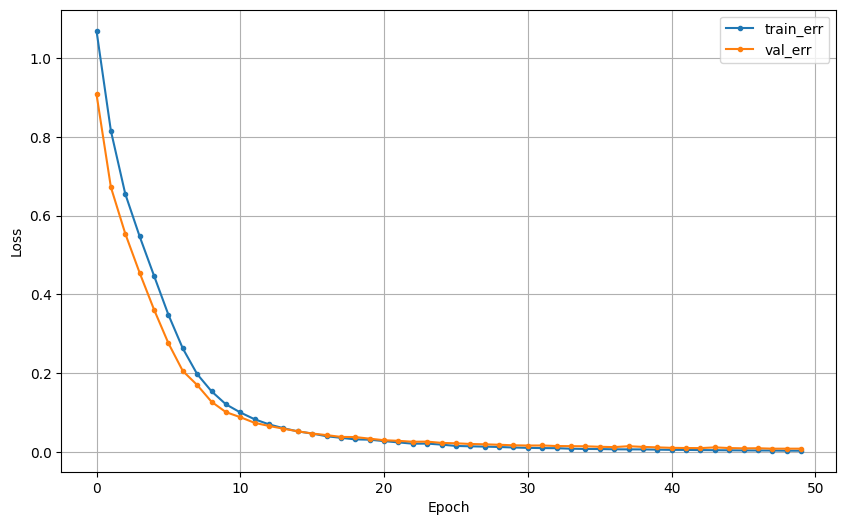

In [32]:
dl_history_plot(history)

In [33]:
pred=model.predict(x_val_temp)

pred=np.argmax(pred, axis=1)
# print(pred)

26/26 [==============================] - 0s 2ms/step


In [34]:
print(classification_report(y_val_temp, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       297
           1       1.00      1.00      1.00       275
           2       1.00      0.98      0.99       239

    accuracy                           0.99       811
   macro avg       0.99      0.99      0.99       811
weighted avg       0.99      0.99      0.99       811



In [35]:
pred=model.predict(new_x_test)

pred=np.argmax(pred, axis=1)
print(classification_report(new_y_1_test, pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       228
           1       1.00      1.00      1.00       215
           2       1.00      0.98      0.99       195

    accuracy                           0.99       638
   macro avg       0.99      0.99      0.99       638
weighted avg       0.99      0.99      0.99       638



In [36]:
# 메모리 정리
clear_session()

# 모델링
nfeatures=561
model = Sequential(
   [ Dense(256, input_shape = (nfeatures,), activation = 'relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation = 'softmax') ]
    )

# 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 187203 (731.26 KB)
Trainable params: 187203 (731.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model.compile(optimizer = Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy')

history=model.fit(x_train_temp, y_train_temp, epochs=50, validation_split=0.2).history

Epoch 1/50
46/46 [==============================] - 3s 17ms/step - loss: 0.5921 - val_loss: 0.2278
Epoch 2/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1753 - val_loss: 0.1860
Epoch 3/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0842 - val_loss: 0.0644
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0507 - val_loss: 0.0308
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0182 - val_loss: 0.0173
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0303 - val_loss: 0.0437
Epoch 7/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0233 - val_loss: 0.0177
Epoch 8/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0103
Epoch 9/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0109
Epoch 10/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0123
Epoch 11/50
46

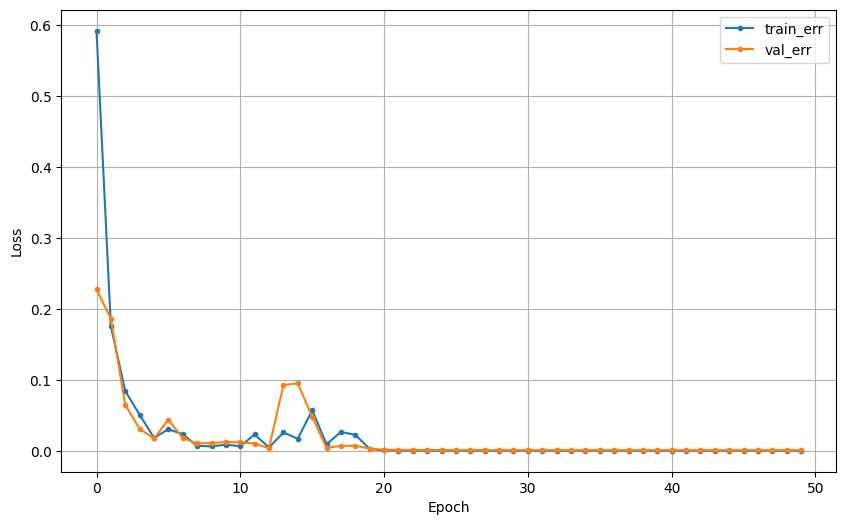

In [38]:
dl_history_plot(history)

In [39]:
pred=model.predict(x_val_temp)

pred=np.argmax(pred, axis=1)
# print(pred)

26/26 [==============================] - 0s 4ms/step


In [40]:
print(classification_report(y_val_temp, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       297
           1       1.00      1.00      1.00       275
           2       1.00      0.98      0.99       239

    accuracy                           0.99       811
   macro avg       0.99      0.99      0.99       811
weighted avg       0.99      0.99      0.99       811



In [41]:
pred=model.predict(new_x_test)

pred=np.argmax(pred, axis=1)
print(classification_report(new_y_1_test, pred))

20/20 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       228
           1       1.00      0.99      0.99       215
           2       1.00      0.99      1.00       195

    accuracy                           1.00       638
   macro avg       1.00      1.00      1.00       638
weighted avg       1.00      1.00      1.00       638



### [선택사항] (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들어서 분류 모델 합치기